<a href="https://colab.research.google.com/github/Bambillo1/elecomsCoding_academy/blob/main/Copy_of_Enhancing_Electricity_Theft_Detection_and_Mitigation_in_Smart_Grid_Through_Hybrid_CNN_RF_and_Advanced_Baseline_Neural_Network_Techniques_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries import
import tensorflow as tf
from tensorflow import keras
import os
import tempfile

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras import Model

from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger, LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.metrics import binary_crossentropy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

from keras.callbacks import ModelCheckpoint
#from plot_keras_history import show_history, plot_history
#from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
#!pip install scikeras
#!pip install plot-keras-history
#from scikeras.wrappers import KerasClassifier

In [2]:
#Setting parameters for plots
mp.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#Mounting data on gdrive


In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Link data residing in gdrive to colab using this link from the data(in gdrive)

In [4]:
!gdown 1pTpBfO1CwStFodOtIn_uzzNOWpAmQn_8

Downloading...
From (original): https://drive.google.com/uc?id=1pTpBfO1CwStFodOtIn_uzzNOWpAmQn_8
From (redirected): https://drive.google.com/uc?id=1pTpBfO1CwStFodOtIn_uzzNOWpAmQn_8&confirm=t&uuid=010f772d-3fa6-4917-a86d-ed9dfd60831c
To: /content/data.csv
100% 175M/175M [00:02<00:00, 63.1MB/s]


Using read_csv to read in data into a dataframe

In [5]:
df = pd.read_csv('data.csv')

#Proportion of flag (1) and not flag(0)

In [6]:
#Proportion of flag (1) and not flag(0)

one = df[df['FLAG'] == 1].shape[0]
zero = df[df['FLAG'] == 0].shape[0]

total = zero + one

In [7]:
total

42372

In [8]:
print(one / (one + zero) * 100, '% of customers flagged.')

print(zero / (one + zero) * 100, '% of customers unflagged.')

8.531577456811101 % of customers flagged.
91.4684225431889 % of customers unflagged.


Visualize data using pie chart

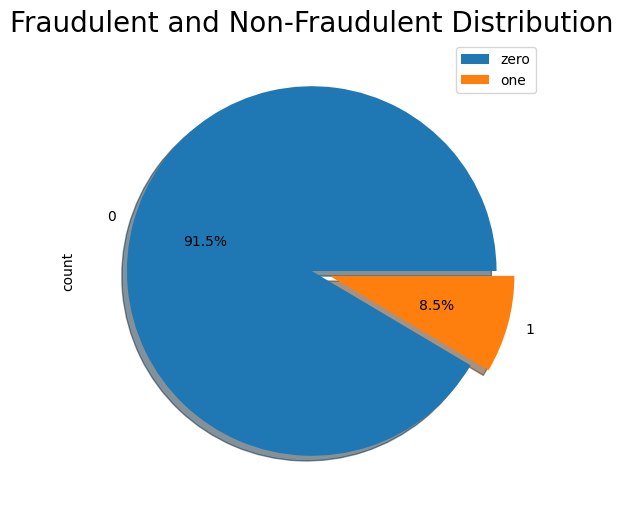

In [9]:
df["FLAG"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Fraudulent and Non-Fraudulent Distribution",fontsize=20)
plt.legend(["zero", "one"])
plt.show()

Check first 10 rows of the df

In [10]:

df.head(10)

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
5,6BCFD78138BC72A9BA1BFB0B79382192,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.82,5.52,3.12,3.13,4.20,3.23,3.85,2.78,3.55,2.54
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.11,0.53,0.45,0.51,1.32,0.71,0.12,0.52,...,4.33,2.46,1.23,3.19,1.17,1.36,0.56,1.02,1.96,1.83
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.91,0.86,1.10,0.66,5.82,3.17,1.18,4.05,...,2.36,2.82,2.28,3.70,3.07,4.61,3.13,3.10,3.74,3.13
8,D0A186208CE83FBCCF730857C9A75B6F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.36,3.41,4.73,3.54,4.20,2.77,3.02,4.06,4.75,4.86
9,516954F5FF177CE314656D727FCC66A5,1,11.02,8.24,7.94,7.92,8.31,7.39,8.27,8.05,...,51.36,52.39,113.35,60.89,115.62,108.69,87.88,86.36,81.51,81.75


Append other columns except for 'CONS_NO','FLAG' columns into a list named Ib

In [11]:
l=df.columns
la=['CONS_NO','FLAG']
lb=[]
for i in l:
    if i not in la:
        lb.append(i)

Format the date in year/month/day mode for all columns and store them in a list fdatesdates

In [12]:

import datetime
dates = [datetime.datetime.strptime(ts, "%Y/%m/%d") for ts in lb]
#dates.sort()
fdatesdates = [datetime.datetime.strftime(ts, "%Y/%m/%d") for ts in dates]

Insert 0 in all rows of column FLAG, same with CON_NO

In [13]:
fdatesdates.insert(0,"FLAG")
fdatesdates.insert(0,"CONS_NO")

df.columns=fdatesdates

Using sort method to sort dates in ascending order

In [14]:
import datetime
dates = [datetime.datetime.strptime(ts, "%Y/%m/%d") for ts in lb]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%Y/%m/%d") for ts in dates]


Concatenate sorted dates AND columns CONS_NO and FLAG

In [15]:
cols=df.columns.tolist()[0:2]+sorteddates
df=df[cols]

Fill all columns with there respective observations

In [16]:
import math
train_df=df
l=train_df["2014/01/01"]
l1=train_df["2014/01/01"]
l=np.asarray(l).tolist()
l1=np.asarray(l1).tolist()

l2=[]
for i in range(len(l)):
    if math.isnan(l[i]):
        if math.isnan(l1[i]):
            l2.append(0)
        else:
            l2.append(l1[i]/2)
    else:
        l2.append(l[i])
train_df["2014/01/01"]=l2

train_df.head()
l=train_df["2016/10/31"]
l1=train_df["2016/10/31"]
l=np.asarray(l).tolist()
l1=np.asarray(l1).tolist()

l2=[]
for i in range(len(l)):
    if math.isnan(l[i]):
        if math.isnan(l1[i]):
            l2.append(0)
        else:
            l2.append(l1[i]/2)
    else:
        l2.append(l[i])
train_df["2016/10/31"]=l2


l=train_df.columns
la=['CONS_NO','FLAG']
lbx=[]
for i in l:
    if i not in la:
        lbx.append(i)





CNS_NO is a categorical columns that contains string objects representing each customer. It is of no use in the dataframe for modelling, thus, dropped or removed.

In [17]:
df = df.drop('CONS_NO', axis = 1)

Using interpolate method for replacing missing values

In [18]:
df=df.interpolate(method ='linear', limit_direction ='forward')
df=df.interpolate(method ='linear', limit_direction ='backward')

Splitting data into train, test and validation sets with test size of 20%, validation 20% and train of 60%

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['FLAG'])
df_train, df_val = train_test_split(df, test_size=0.2, stratify = df['FLAG'])

In [20]:
#Check first 5 rows of df
df_train.head()

,FLAG,2014/01/01,2014/01/02,2014/01/03,2014/01/04,2014/01/05,2014/01/06,2014/01/07,2014/01/08,2014/01/09,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
32824,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.10,11.92,7.26,13.91,5.87,9.43,5.58,6.63,4.70,6.22
6646,0,13.46,12.47,13.81,13.20,15.00,13.73,11.38,11.39,12.51,...,7.56,10.11,10.31,10.26,5.89,9.00,10.23,7.76,6.66,7.07
27529,0,0.00,8.90,8.58,11.31,7.09,0.00,0.00,9.06,8.30,...,10.70,7.45,9.67,9.18,9.43,10.00,9.33,4.47,11.18,8.20
27656,0,0.20,0.22,0.24,0.24,0.23,0.23,0.00,0.25,0.24,...,0.57,0.59,0.57,0.55,0.66,0.60,0.61,0.62,0.51,0.48
4809,0,0.00,1.77,1.99,1.89,1.70,2.20,1.97,1.86,0.00,...,3.34,3.67,3.85,4.82,5.10,4.17,3.79,3.32,3.62,3.77


In [21]:
df_test

,FLAG,2014/01/01,2014/01/02,2014/01/03,2014/01/04,2014/01/05,2014/01/06,2014/01/07,2014/01/08,2014/01/09,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
8586,0,5.92,5.960,4.560,3.580,3.530,4.520,5.110,4.630,5.460,...,5.86,6.90,3.79,6.13,6.38,7.88,7.10,6.42,5.70,5.73
17454,0,0.00,17.490,11.916,10.668,13.886,10.278,11.732,13.960,12.110,...,22.24,24.90,17.53,16.04,17.41,21.66,22.53,21.55,15.26,12.23
41112,0,5.78,8.430,7.660,6.760,8.200,8.410,5.900,8.120,6.960,...,4.02,4.61,4.64,3.84,4.64,4.73,4.01,4.06,4.98,5.52
7985,0,5.33,4.960,6.890,5.890,3.950,7.080,7.110,5.480,18.320,...,13.30,9.64,7.77,10.15,10.53,10.50,13.16,8.57,11.34,7.35
37777,0,0.00,17.722,18.776,18.544,20.662,19.538,20.038,18.908,19.698,...,0.18,0.00,0.00,0.00,0.00,0.90,1.02,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,0,14.26,14.760,20.940,15.680,14.460,18.350,18.080,14.420,15.910,...,14.58,15.57,12.36,12.79,14.92,12.93,18.10,16.20,15.89,18.59
26487,0,4.83,7.400,3.340,0.270,1.680,4.040,5.460,4.740,4.820,...,3.38,5.39,7.61,8.22,6.85,8.04,5.39,2.83,4.00,7.73
11805,0,0.00,0.990,0.300,0.020,0.020,0.010,0.020,0.020,0.920,...,0.93,0.01,2.06,0.90,1.87,2.22,1.67,1.09,1.76,1.36
1597,1,0.00,8.060,10.430,9.245,9.555,7.530,6.905,7.920,10.545,...,3.37,2.70,2.47,3.29,4.57,3.05,3.11,2.71,3.49,2.49


In [22]:
df_val

,FLAG,2014/01/01,2014/01/02,2014/01/03,2014/01/04,2014/01/05,2014/01/06,2014/01/07,2014/01/08,2014/01/09,...,2016/10/22,2016/10/23,2016/10/24,2016/10/25,2016/10/26,2016/10/27,2016/10/28,2016/10/29,2016/10/30,2016/10/31
2872,1,0.00,136.108000,141.144000,141.096000,112.034000,114.378000,121.932000,140.704000,128.764000,...,57.17,77.39,72.32,76.37,59.59,34.68,39.88,43.22,35.13,32.46
25296,0,14.19,14.270000,15.340000,16.540000,15.360000,16.950000,14.500000,15.550000,14.820000,...,14.73,13.53,12.00,13.19,12.96,11.80,12.51,12.86,12.80,13.70
7099,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.66,4.46,3.53,3.51,3.82,3.83,3.50,3.37,4.80,3.45
16119,0,0.00,4.106667,5.533333,5.206667,5.740000,8.786667,6.200000,4.073333,9.146667,...,0.99,2.30,1.66,2.42,2.07,1.65,1.73,2.15,1.27,2.73
41136,0,0.00,0.260000,0.270000,0.000000,0.266667,0.270000,0.260000,0.270000,0.286667,...,5.71,7.91,5.14,3.62,3.78,3.22,5.08,2.44,1.85,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24771,0,0.00,7.653333,8.122222,8.366667,8.328889,6.477778,8.128889,7.946667,8.052222,...,5.78,4.09,6.80,7.39,4.62,5.59,11.19,5.93,8.00,4.15
23506,0,2.44,1.190000,1.210000,1.250000,1.180000,1.470000,1.240000,1.250000,1.190000,...,1.11,1.17,1.26,1.05,1.26,1.18,1.17,1.05,0.98,0.96
21331,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.68,5.92,3.70,3.53,3.42,3.19,2.26,2.83,2.13,1.98
35306,0,0.00,5.506667,1.750000,9.340000,5.350000,5.286667,7.183333,1.546667,5.653333,...,0.02,0.01,0.06,0.01,0.00,0.00,0.00,0.00,0.01,0.01


In [23]:
# Convert dataframe into  numpy arrays of labels and features.
df_train_labels = np.array(df_train.pop('FLAG'))   #pop function means remove FLAG from the train data

In [24]:
df_val_labels = np.array(df_val.pop('FLAG'))  #pop function means remove FLAG from the val data

In [25]:
df_test_labels = np.array(df_test.pop('FLAG'))#pop function means remove FLAG from the test data

In [26]:
bin_train_labels = df_train_labels != 0 #Where df_train_labels is not equal to zero

In [27]:
df_train_features = np.array(df_train) #This is now  a numpy array of train data

In [28]:
df_val_features = np.array(df_val)   ##This is now  a numpy array of val data

In [29]:
df_test_features = np.array(df_test)#This is now  a numpy array of test data

In [30]:
df_train_features.shape #Check no of rows and columns of train data

(33897, 1034)

Use MinMaxScaler to normalize all features i -: Uniform Scale

In [31]:
scale_features = MinMaxScaler()

In [32]:
df_train_features = scale_features.fit_transform(df_train_features)

In [33]:
df_val_features = scale_features.transform(df_val_features)

In [34]:
df_test_features = scale_features.transform(df_test_features)

In [35]:
df_train_features = np.clip(df_train_features, -5, 5) #Remove any observation less and equal to -5 and less than and greater than 5

In [36]:
df_val_features = np.clip(df_val_features, -5, 5)

In [37]:
df_test_features = np.clip(df_test_features, -5, 5)

In [38]:
print(' Shape of training labels: ', df_train_labels.shape)
print(' Shape of validation labels: ', df_val_labels.shape)
print(' Shape of test labels: ', df_test_labels.shape)

 Shape of training labels:  (33897,)
 Shape of validation labels:  (8475,)
 Shape of test labels:  (8475,)


Print the shapes of all features

In [39]:
print('Shape of training features : ', df_train_features.shape)
print('Shape of validation features: ', df_val_features.shape)
print('Shape of test features: ', df_test_features.shape)

Shape of training features :  (33897, 1034)
Shape of validation features:  (8475, 1034)
Shape of test features:  (8475, 1034)


Build a function for performance metrics and baseline model

In [40]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'),
                        ]

def make_model(metrics=METRICS, output_bias=None):

  if output_bias is not None:

    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([keras.layers.Dense(32, activation='relu',input_shape=(df_train_features.shape[-1],)),

      keras.layers.Flatten(),

      keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'he_uniform'),

      keras.layers.Dropout(0.7),

      keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'he_uniform'),

      keras.layers.Dropout(0.7),

      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=metrics)

  return model

Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

#Baseline Model
early_stopping is when there is convergence during training-It means training stops where same scores are being repeated at every epoch

In [103]:
epochs = 100  # no of iterations the neurons tranverses the network
batch_size = 2048 # Each batch of data that are entering the network at a time

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./model/model.keras', monitor='val_prc', verbose=1, save_best_only=True, mode='max')

In [105]:
# Save the trained model (architecture + weights)
model_path = './model/model.keras'
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ./model/model.keras


In [106]:
model = make_model() # invoking make_model function created above
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 32)                33120     
                                                                 
 flatten_8 (Flatten)         (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 32)                1056      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_34 (Dense)            (None, 64)                2112      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                

We are now predicting the probabilites using the intial weights assigned and the initial predictions are not that generalized. Many of the values are predicted as fraud transactions (probability > 0.5). We can see that the class imbalance is not learnt by the model and it will take a few epochs for the model to learn that there are very less fraud transactions.

In [107]:
model.predict(df_train_features[:15])

1/1 [==============================] - 0s 73ms/step


array([[0.8390459 ],
       [0.8393337 ],
       [0.83997303],
       [0.8390982 ],
       [0.83927107],
       [0.83955765],
       [0.83896744],
       [0.83891094],
       [0.83914816],
       [0.8393697 ],
       [0.8409244 ],
       [0.839123  ],
       [0.83870655],
       [0.8390125 ],
       [0.83944875]], dtype=float32)

#Understanding Initial Loss
Evaluate the model of training data and check the initial loss during training.
When initializing the biases of the neural network's final layer (the layer connected to the sigmoid activation) to their default values,
it is often set such that the initial predicted probability is around 0.5 for both classes. This makes sense because, in the beginning,
the model has no knowledge about the data distribution, and it's a reasonable assumption that both classes are equally likely.
According to this if for one sample we assume the probability as 0.5 and calculate the loss using binary crossentropy, out initial loss should be:
log(2) = 0.69314

In [108]:
returns = model.evaluate(df_train_features, df_train_labels, batch_size=batch_size, verbose=0)
print("The initial model loss is {:0.5f}".format(returns[0]))

The initial model loss is 1.68717


Bias of the model is the logarithm of proportion of positive divided by the negative  class

In [109]:
first_bias = np.log([one/zero])
first_bias

array([-2.37221953])

Using the first bias above in the baseline model function to make prediction on train data

In [110]:
model = make_model(output_bias=first_bias)
model.predict(df_train_features[:15])

1/1 [==============================] - 0s 67ms/step


array([[0.08664002],
       [0.08694164],
       [0.08676616],
       [0.0862212 ],
       [0.08643191],
       [0.08655179],
       [0.08679117],
       [0.08642434],
       [0.08635746],
       [0.08627646],
       [0.08602723],
       [0.08625355],
       [0.08626351],
       [0.08631106],
       [0.08678064]], dtype=float32)

This shows that our loss remains stagnant as there is no change in values of initial loss and returns_later below

In [111]:
returns_later = model.evaluate(df_train_features, df_train_labels, batch_size=batch_size, verbose=0)
print("Loss: {:0.5f}".format(returns_later[0]))

Loss: 0.29139


#Checkpoint the initial weights¶
To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training: This statement means the model should be trained and save somewhere. If we need to start it again, we check where it's saved and import it into the system for more training.

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [112]:
first_weights = os.path.join(tempfile.mkdtemp(), 'first_weights')
model.save_weights(first_weights)

Assign 0 to be weight of the last layer(-1) and train the data on train data and validate with validation data

In [113]:
model = make_model()
model.load_weights(first_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(df_train_features, df_train_labels, batch_size=batch_size, epochs=20, validation_data=(df_val_features, df_val_labels),  verbose=0)

Train the data as above but by assigning1 as weight of the last layer

In [114]:
model = make_model()
model.load_weights(first_weights)
careful_bias_history = model.fit(df_train_features, df_train_labels, batch_size=batch_size, epochs=20,  validation_data=(df_val_features, df_val_labels),  verbose=0)

Create a plot function to plot zero_bias and creful_bias trainings

In [115]:
def plot_loss_model(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

Invoking the function to plot the two biases

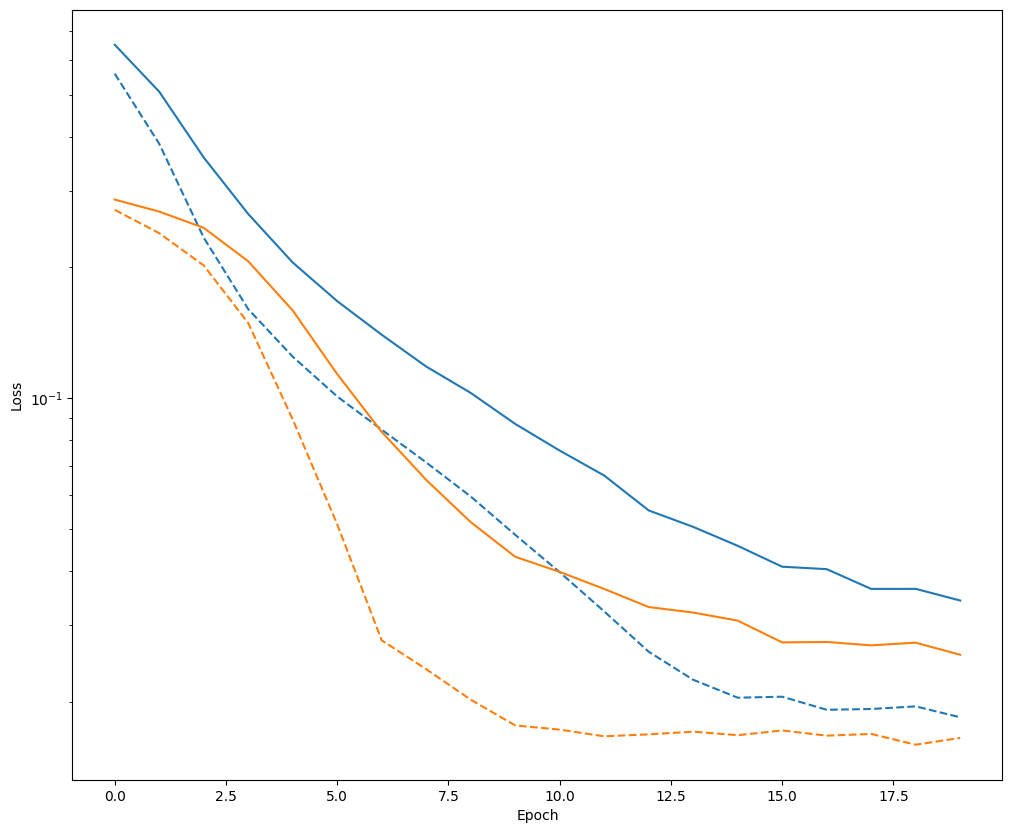

In [116]:
plot_loss_model(zero_bias_history, "Zero Bias", 0)
plot_loss_model(careful_bias_history, "Careful Bias", 1)

From the checkpoint, baseline model we saved earlier is now eing loaded for training

In [117]:
model = make_model()
model.load_weights(first_weights)
baseline_model_history = model.fit(df_train_features, df_train_labels, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], validation_data=(df_val_features, df_val_labels))

Epoch 1/100
17/17 [==============================] - 5s 119ms/step - loss: 0.2867 - tp: 713.0000 - fp: 5.0000 - tn: 38752.0000 - fn: 2902.0000 - accuracy: 0.9314 - precision: 0.9930 - recall: 0.1972 - auc: 0.7501 - prc: 0.3622 - val_loss: 0.2702 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 7752.0000 - val_fn: 718.0000 - val_accuracy: 0.9153 - val_precision: 1.0000 - val_recall: 0.0069 - val_auc: 0.9727 - val_prc: 0.6972
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2689 - tp: 44.0000 - fp: 17.0000 - tn: 30988.0000 - fn: 2848.0000 - accuracy: 0.9155 - precision: 0.7213 - recall: 0.0152 - auc: 0.8017 - prc: 0.3324 - val_loss: 0.2393 - val_tp: 16.0000 - val_fp: 6.0000 - val_tn: 7746.0000 - val_fn: 707.0000 - val_accuracy: 0.9159 - val_precision: 0.7273 - val_recall: 0.0221 - val_auc: 0.9761 - val_prc: 0.7524
Epoch 3/100
17/17 [==============================] - 1s 35ms/step - loss: 0.2424 - tp: 125.0000 - fp: 53.0000 - tn: 30952.0000 - fn: 2767.0000 - accur

This function plots model metric function defined earlier: precision,recall, prc, loss

In [118]:
def plot_model_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.9,1])
    else:
      plt.ylim([0,1])

    plt.legend()

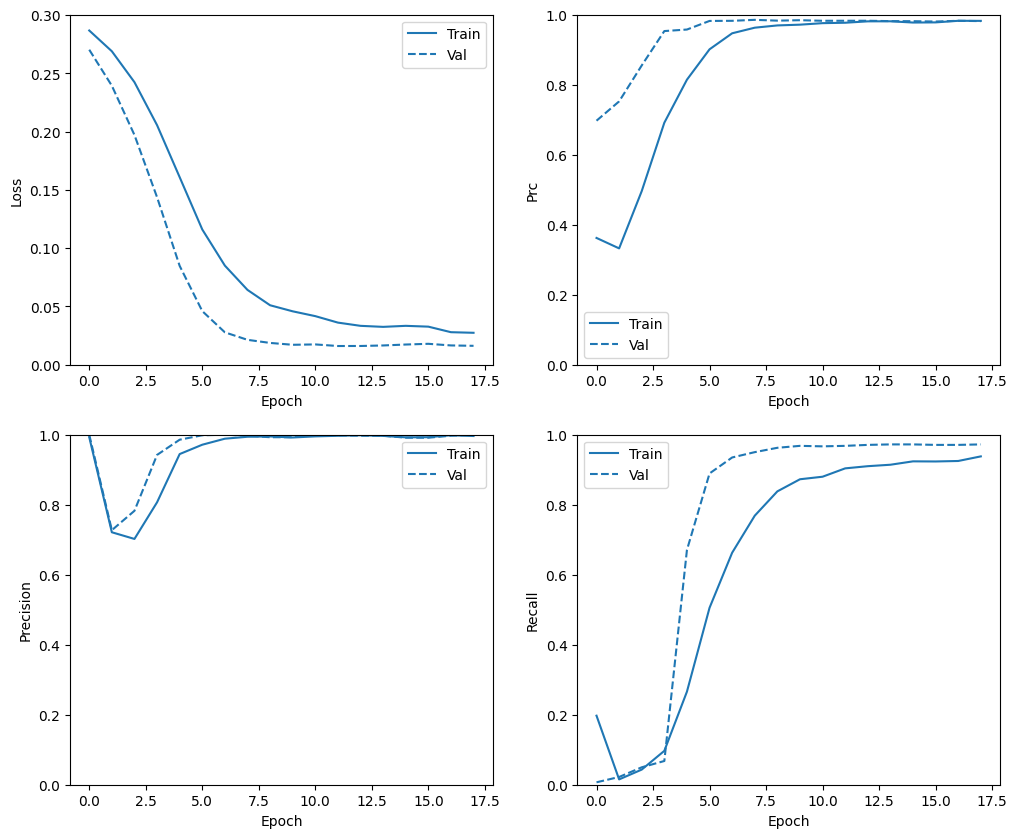

In [119]:
plot_model_metrics(baseline_model_history)

Make pediction with baselime model on both train and test data

In [120]:
train_predictions_baseline = model.predict(df_train_features, batch_size=batch_size)
test_predictions_baseline = model.predict(df_test_features, batch_size=batch_size)

5/5 [==============================] - 0s 8ms/step


This function plots confusion matrix forthe baseline model

In [121]:
def plot_cm_model(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-Theft correctly Detected (TN): ', cm[0][0])
  print('Non-theft Incorrectly Detected (FP): ', cm[0][1])
  print('Theft incorrectly Detected (FN): ', cm[1][0])
  print('Theft correctly Detected (TP): ', cm[1][1])
  print('Total theft Detections: ', np.sum(cm[1]))

#Evaluate your model on the test dataset and display the results for the metrics you created above:
If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate connections that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent connections to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their energy card activity.

loss :  0.019239002838730812
tp :  695.0
fp :  3.0
tn :  7749.0
fn :  28.0
accuracy :  0.9963421821594238
precision :  0.9957020282745361
recall :  0.9612724781036377
auc :  0.9922564625740051
prc :  0.9874348640441895

Non-Theft correctly Detected (TN):  7749
Non-theft Incorrectly Detected (FP):  3
Theft incorrectly Detected (FN):  28
Theft correctly Detected (TP):  695
Total theft Detections:  723


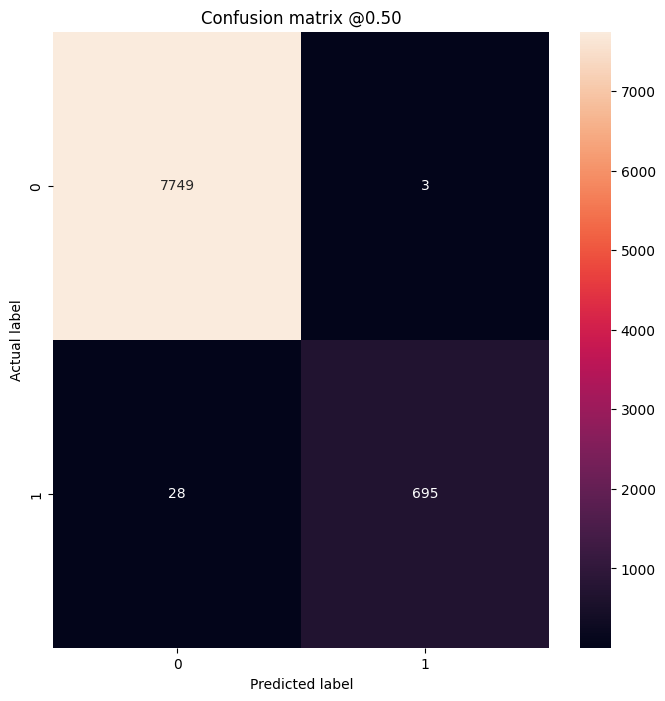

In [122]:
baseline_model_results = model.evaluate(df_test_features, df_test_labels, batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, baseline_model_results):
  print(name, ': ', value)
print()

plot_cm_model(df_test_labels, test_predictions_baseline)

This function plots roc curve of the baseline model

In [123]:
def plot_roc_model(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([40,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

Invoking roc_model function with real arguments

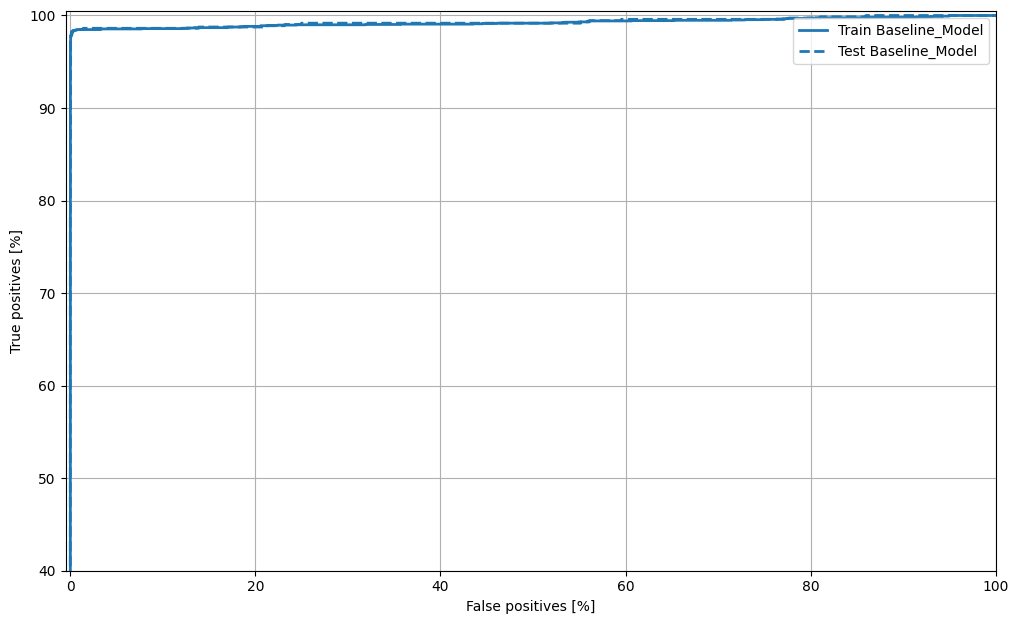

In [124]:
plot_roc_model("Train Baseline_Model", df_train_labels, train_predictions_baseline, color=colors[0])
plot_roc_model("Test Baseline_Model", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='upper right');

This function plots prc of the baseline model

In [125]:
def plot_model_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

Invoking model_prc function with real arguments

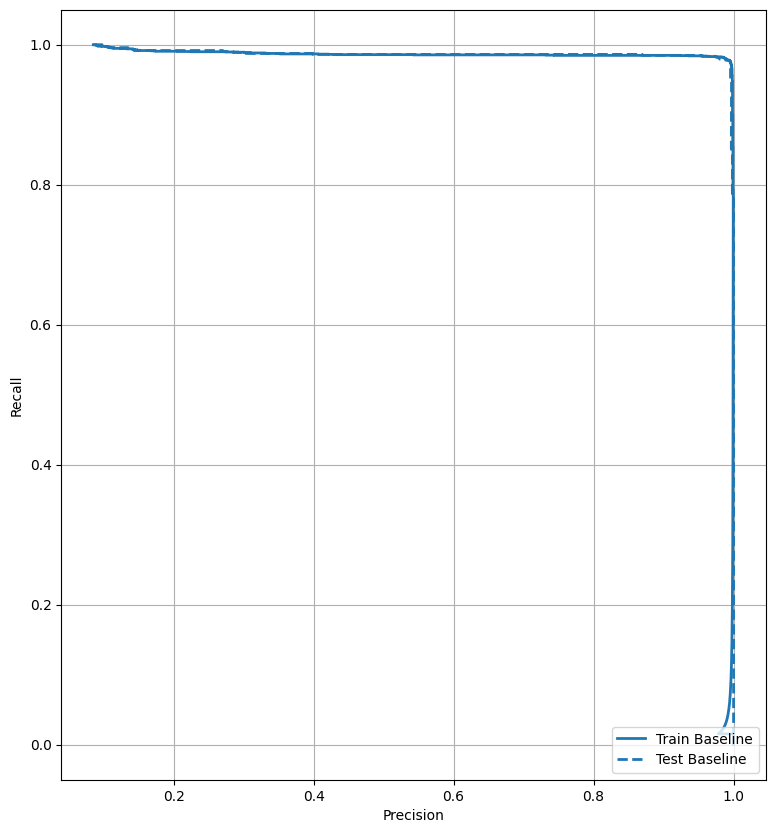

In [126]:
plot_model_prc("Train Baseline", df_train_labels, train_predictions_baseline, color=colors[0])
plot_model_prc("Test Baseline", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

##Calculate class weights
The goal is to identify fraudulent connections, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class (1).

In [127]:
# Scaling by total/2 helps keep the loss to a similar value.
# The sum of the weights of all examples stays the same.
weight_0 = (1 / zero) * (total / 2.0)
weight_1 = (1 / one) * (total / 2.0)

class_weight = {0: weight_0, 1: weight_1}

print('Weight for class negative (0): {:.2f}'.format(weight_0))
print('Weight for class positive (1): {:.2f}'.format(weight_1))

Weight for class negative (0): 0.55
Weight for class positive (1): 5.86


Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like tf.keras.optimizers.SGD, may fail. The optimizer used here, tf.keras.optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [128]:
weighted_model = make_model()
weighted_model.load_weights(first_weights)

weighted_history = weighted_model.fit(df_train_features,df_train_labels,batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], validation_data=(df_val_features, df_val_labels), class_weight=class_weight)


Epoch 1/100
17/17 [==============================] - 4s 104ms/step - loss: 1.1808 - tp: 738.0000 - fp: 27.0000 - tn: 38730.0000 - fn: 2877.0000 - accuracy: 0.9315 - precision: 0.9647 - recall: 0.2041 - auc: 0.6710 - prc: 0.3343 - val_loss: 0.2894 - val_tp: 26.0000 - val_fp: 14.0000 - val_tn: 7738.0000 - val_fn: 697.0000 - val_accuracy: 0.9161 - val_precision: 0.6500 - val_recall: 0.0360 - val_auc: 0.6676 - val_prc: 0.2200
Epoch 2/100
17/17 [==============================] - 1s 41ms/step - loss: 0.9419 - tp: 294.0000 - fp: 749.0000 - tn: 30256.0000 - fn: 2598.0000 - accuracy: 0.9013 - precision: 0.2819 - recall: 0.1017 - auc: 0.5919 - prc: 0.1551 - val_loss: 0.3369 - val_tp: 126.0000 - val_fp: 152.0000 - val_tn: 7600.0000 - val_fn: 597.0000 - val_accuracy: 0.9116 - val_precision: 0.4532 - val_recall: 0.1743 - val_auc: 0.8238 - val_prc: 0.3123
Epoch 3/100
17/17 [==============================] - 1s 41ms/step - loss: 0.7193 - tp: 1017.0000 - fp: 2979.0000 - tn: 28026.0000 - fn: 1875.0000 

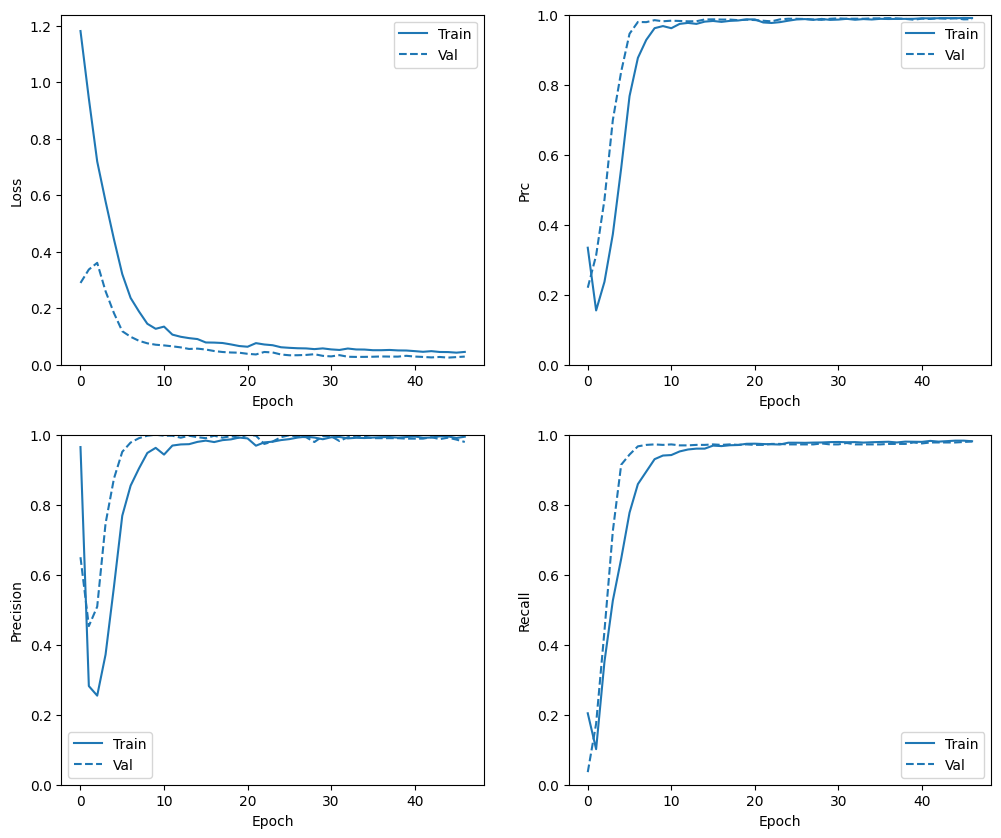

In [129]:
plot_model_metrics(weighted_history)

Make prediction with class weight calculate above on both train and test data

In [130]:
train_predictions_weighted = weighted_model.predict(df_train_features, batch_size=batch_size)
test_predictions_weighted = weighted_model.predict(df_test_features, batch_size=batch_size)

5/5 [==============================] - 0s 6ms/step


Print results using confusion matrix for class weight

loss :  0.026122184470295906
tp :  710.0
fp :  2.0
tn :  7750.0
fn :  13.0
accuracy :  0.9982300996780396
precision :  0.9971910119056702
recall :  0.9820193648338318
auc :  0.993785560131073
prc :  0.9909684658050537

Non-Theft correctly Detected (TN):  7750
Non-theft Incorrectly Detected (FP):  2
Theft incorrectly Detected (FN):  13
Theft correctly Detected (TP):  710
Total theft Detections:  723


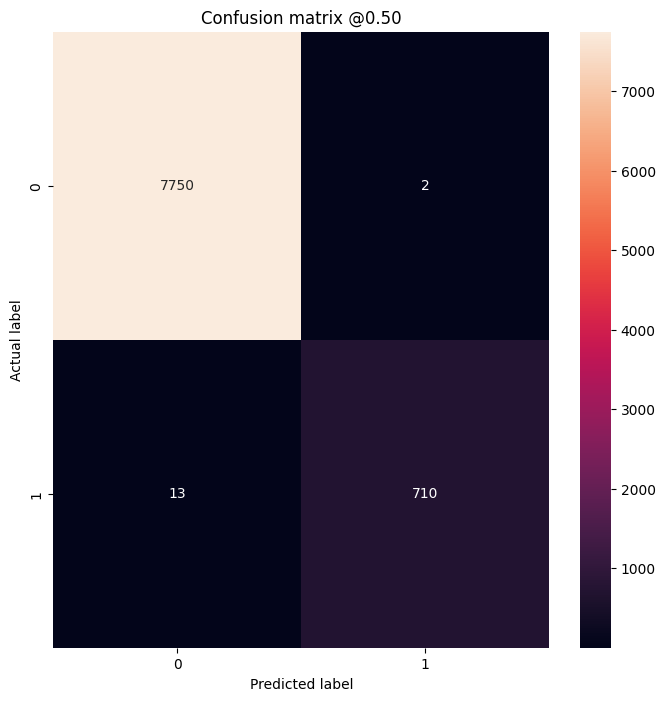

In [131]:
weighted_results = weighted_model.evaluate(df_test_features, df_test_labels, batch_size=batch_size, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm_model(df_test_labels, test_predictions_weighted)

Also plot roc for the baseline model and weighted mdel using train and test data

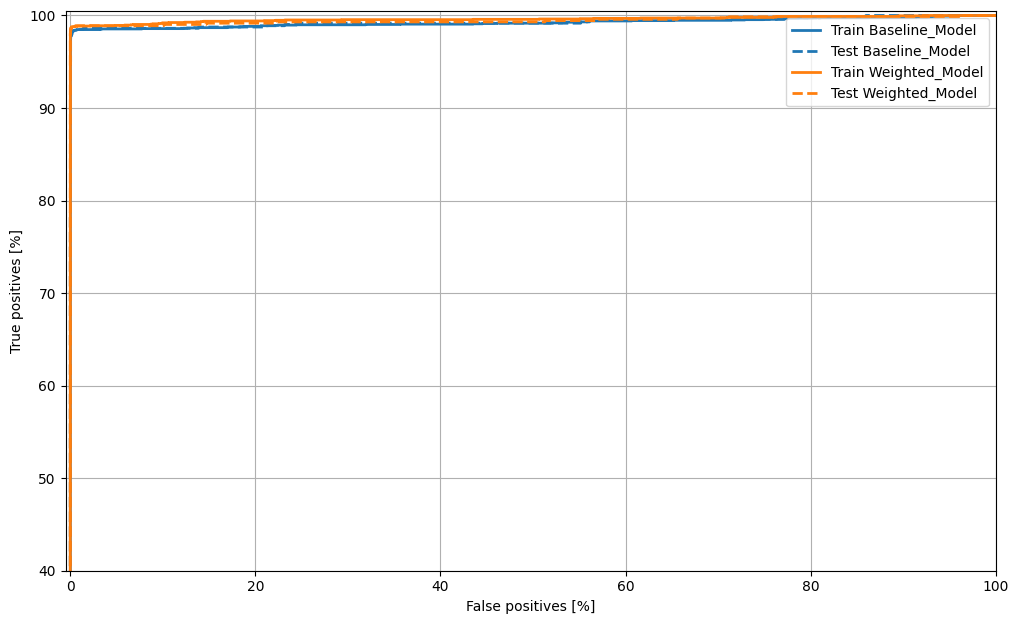

In [132]:
plot_roc_model("Train Baseline_Model", df_train_labels, train_predictions_baseline, color=colors[0])
plot_roc_model("Test Baseline_Model", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc_model("Train Weighted_Model", df_train_labels, train_predictions_weighted, color=colors[1])
plot_roc_model("Test Weighted_Model", df_test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='upper right');

Invoking prc function for baseline and weighted models using train and test data

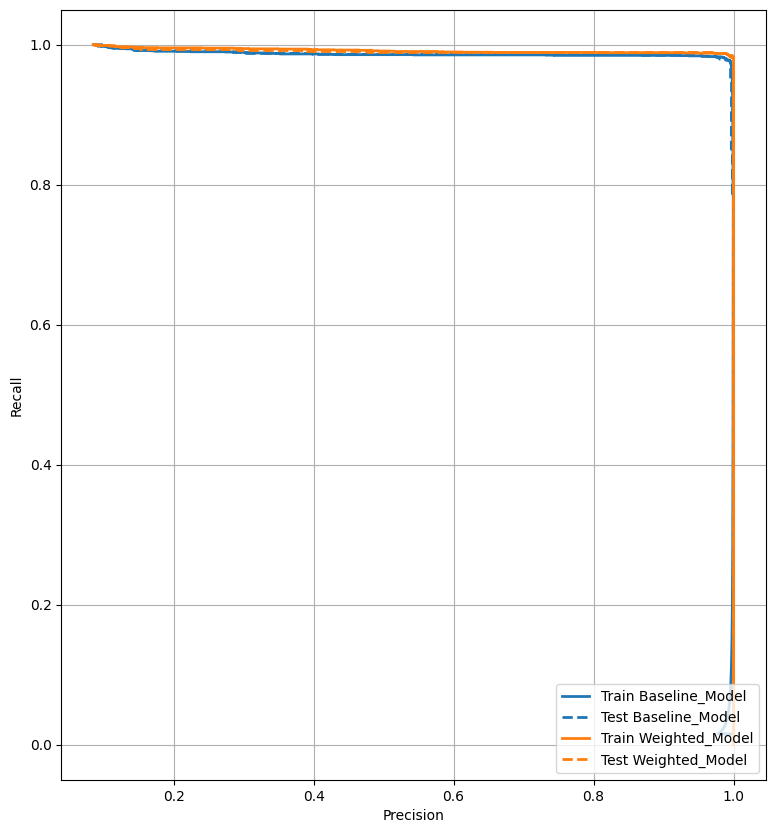

In [133]:
plot_model_prc("Train Baseline_Model", df_train_labels, train_predictions_baseline, color=colors[0])
plot_model_prc("Test Baseline_Model", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_model_prc("Train Weighted_Model", df_train_labels, train_predictions_weighted, color=colors[1])
plot_model_prc("Test Weighted_Model", df_test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

#Oversample the minority class

In [134]:
one_features = df_train_features[bin_train_labels]      #train data for only where FLAG == 1
zero_features = df_train_features[~bin_train_labels]   #train data for only where FLAG == 0

In [135]:
one_labels = df_train_labels[bin_train_labels]#train LABELS for only where FLAG == 1
zero_labels = df_train_labels[~bin_train_labels]#train LABELS for only where FLAG == 0

In [136]:
(one_labels[:20], zero_labels[:20]) #Print first 20 for 1 and 0 labels

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

You can balance the dataset manually by choosing the right number of random indices from the positive examples:¶

Using numpy random module to shuffle the data and make some choice of 1 and 0 features.

This step tries to oversample the minority 1 class to e equal to the majority 0 class.

In [137]:
ids = np.arange(len(one_features))
choices = np.random.choice(ids, len(zero_features))

In [138]:
res_one_features = one_features[choices]
res_one_labels = one_labels[choices]

res_one_features.shape

(31005, 1034)

Adding or concatenating 1 and 0 features together gives us a resampled features of 62010 rows and 1034 columns

With tf.data from tensorflow, the easiest way to produce balanced examples is to start with a one and a zero dataset, and concatenate them.

In [139]:
resampled_features = np.concatenate([res_one_features, zero_features], axis=0)
resampled_labels = np.concatenate([res_one_labels, zero_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]


In [140]:
resampled_features.shape

(62010, 1034)

Using tensorflow, create a function that shuffles our oversampled data and returns a shuffled dataset.

In [141]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

one_ds = make_ds(one_features, one_labels)
zero_ds = make_ds(zero_features, zero_labels)

Print a sample of a row from the dataset for feature and label

In [142]:
for features, label in one_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [0.         0.00050473 0.00051399 ... 0.         0.         0.        ]

Label:  1


Merge the two together using tf.data.Dataset.sample_from_datasets:

In [143]:
resampled_ds = tf.data.Dataset.sample_from_datasets([one_ds, zero_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(batch_size).prefetch(2)

In [144]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49755859375


To use this dataset, you'll need the number of steps per epoch.

epoch here is the number of batches required to see each negative example once:

In [145]:
resampled_steps_per_epoch = np.ceil(2.0*zero/batch_size)
resampled_steps_per_epoch

38.0

## Train on the oversampled data
Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.
Invoke baseline model function with oversampled data

In [146]:
resampled_model = make_model()
resampled_model.load_weights(first_weights)

In [147]:
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [148]:
val_ds = tf.data.Dataset.from_tensor_slices((df_val_features, df_val_labels)).cache()
val_ds = val_ds.batch(batch_size).prefetch(2)

In [149]:
resampled_history = resampled_model.fit(resampled_ds, epochs=epochs, steps_per_epoch=resampled_steps_per_epoch, callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/100
38/38 [==============================] - 9s 115ms/step - loss: 0.6379 - tp: 26847.0000 - fp: 12533.0000 - tn: 34172.0000 - fn: 12747.0000 - accuracy: 0.7071 - precision: 0.6817 - recall: 0.6781 - auc: 0.8005 - prc: 0.7587 - val_loss: 0.4961 - val_tp: 663.0000 - val_fp: 151.0000 - val_tn: 7601.0000 - val_fn: 60.0000 - val_accuracy: 0.9751 - val_precision: 0.8145 - val_recall: 0.9170 - val_auc: 0.9819 - val_prc: 0.7959
Epoch 2/100
38/38 [==============================] - 3s 91ms/step - loss: 0.4347 - tp: 33201.0000 - fp: 4802.0000 - tn: 33914.0000 - fn: 5907.0000 - accuracy: 0.8624 - precision: 0.8736 - recall: 0.8490 - auc: 0.9346 - prc: 0.9329 - val_loss: 0.1582 - val_tp: 671.0000 - val_fp: 35.0000 - val_tn: 7717.0000 - val_fn: 52.0000 - val_accuracy: 0.9897 - val_precision: 0.9504 - val_recall: 0.9281 - val_auc: 0.9912 - val_prc: 0.9349
Epoch 3/100
38/38 [==============================] - 5s 132ms/step - loss: 0.2351 - tp: 36286.0000 - fp: 1862.0000 - tn: 36872.0000 - fn: 

When training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

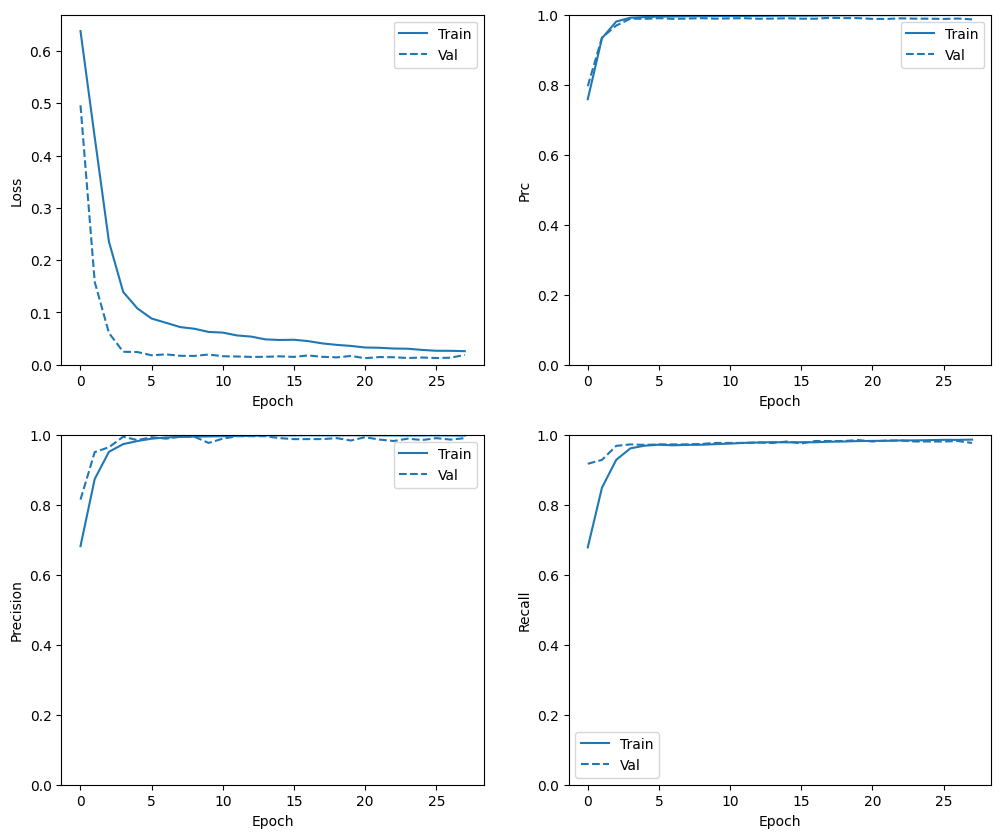

In [150]:
plot_model_metrics(resampled_history)

Make prediction with train and test data on oversampled model

In [151]:
train_predictions_resampled = resampled_model.predict(df_train_features, batch_size=batch_size)
test_predictions_resampled = resampled_model.predict(df_test_features, batch_size=batch_size)

5/5 [==============================] - 0s 6ms/step


Evaluate the oversampled model with test data

In [152]:
resampled_results = resampled_model.evaluate(df_test_features, df_test_labels,  batch_size=batch_size, verbose=0)

Calling plot_cm_model with test data and predictions from oversampled model

loss :  0.011071986518800259
tp :  716.0
fp :  6.0
tn :  7746.0
fn :  7.0
accuracy :  0.9984660744667053
precision :  0.9916897416114807
recall :  0.9903181195259094
auc :  0.9977096915245056
prc :  0.9954581260681152

Non-Theft correctly Detected (TN):  7746
Non-theft Incorrectly Detected (FP):  6
Theft incorrectly Detected (FN):  7
Theft correctly Detected (TP):  716
Total theft Detections:  723


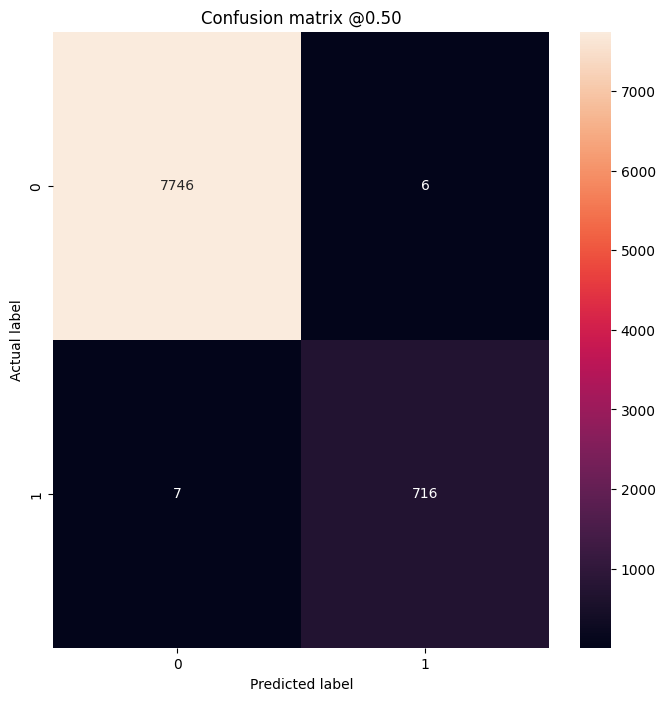

In [153]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm_model(df_test_labels, test_predictions_resampled)

Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the tf.keras.callbacks.EarlyStopping finer control over when to stop training.

In [154]:
resampled_model = make_model()
resampled_model.load_weights(first_weights)

Increase number of epochs by multiplying by 10 = 100*10 and train the oversampled model again

In [155]:
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])
resampled_history = resampled_model.fit(resampled_ds, steps_per_epoch=20, epochs=10*epochs, callbacks=[early_stopping], validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 7s 200ms/step - loss: 0.6719 - tp: 12927.0000 - fp: 7907.0000 - tn: 20361.0000 - fn: 8240.0000 - accuracy: 0.6734 - precision: 0.6205 - recall: 0.6107 - auc: 0.7622 - prc: 0.6527 - val_loss: 0.5956 - val_tp: 623.0000 - val_fp: 142.0000 - val_tn: 7610.0000 - val_fn: 100.0000 - val_accuracy: 0.9714 - val_precision: 0.8144 - val_recall: 0.8617 - val_auc: 0.9795 - val_prc: 0.7588
Epoch 2/1000
20/20 [==============================] - 2s 112ms/step - loss: 0.5929 - tp: 15063.0000 - fp: 4398.0000 - tn: 16056.0000 - fn: 5443.0000 - accuracy: 0.7597 - precision: 0.7740 - recall: 0.7346 - auc: 0.8455 - prc: 0.8336 - val_loss: 0.4562 - val_tp: 658.0000 - val_fp: 153.0000 - val_tn: 7599.0000 - val_fn: 65.0000 - val_accuracy: 0.9743 - val_precision: 0.8113 - val_recall: 0.9101 - val_auc: 0.9811 - val_prc: 0.7808
Epoch 3/1000
20/20 [==============================] - 2s 90ms/step - loss: 0.4668 - tp: 17385.0000 - fp: 2927.0000 - tn: 17551.0000 - f

Re-plot the metrics for the re-trained oversampled model above

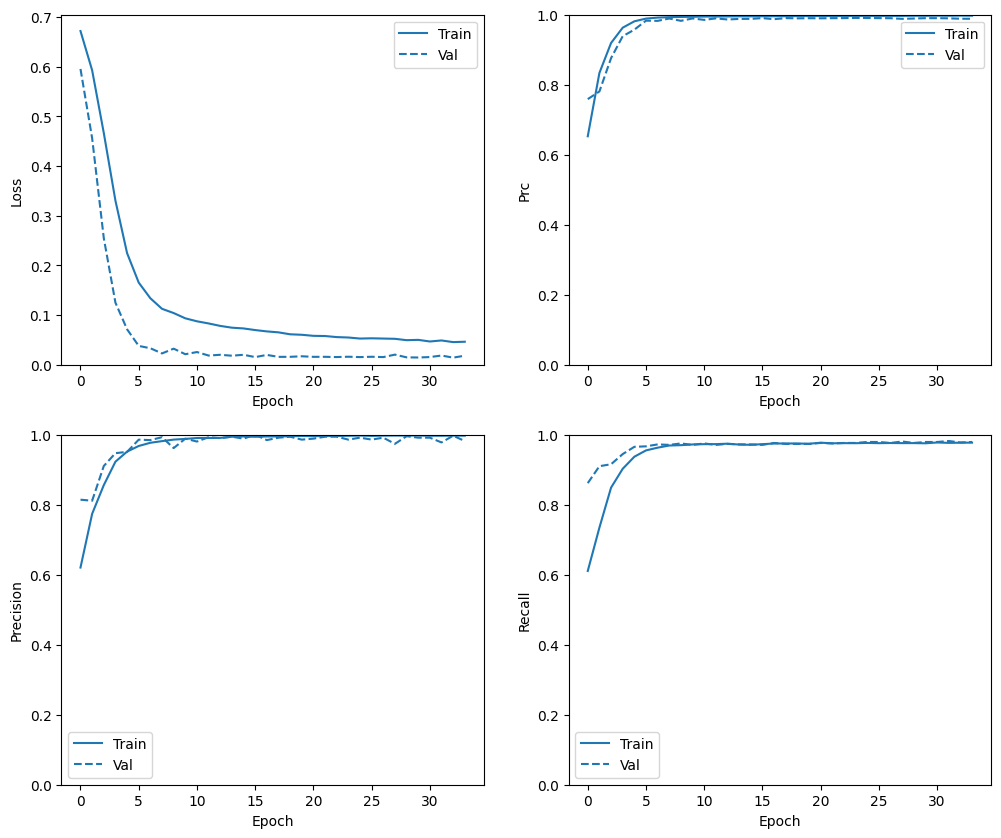

In [156]:
plot_model_metrics(resampled_history)

Make prediction for the oversampled model using train and test data

In [157]:
train_predictions_resampled = resampled_model.predict(df_train_features, batch_size=batch_size)
test_predictions_resampled = resampled_model.predict(df_test_features, batch_size=batch_size)

5/5 [==============================] - 0s 25ms/step


Evaluate the re-oversampled model with test data

In [158]:
resampled_results = resampled_model.evaluate(df_test_features, df_test_labels, batch_size=batch_size, verbose=0)

Print the results of all metrics for the re-oversampled model

loss :  0.01190272718667984
tp :  713.0
fp :  4.0
tn :  7748.0
fn :  10.0
accuracy :  0.99834805727005
precision :  0.9944211840629578
recall :  0.9861687421798706
auc :  0.9956633448600769
prc :  0.9924444556236267

Non-Theft correctly Detected (TN):  7748
Non-theft Incorrectly Detected (FP):  4
Theft incorrectly Detected (FN):  10
Theft correctly Detected (TP):  713
Total theft Detections:  723


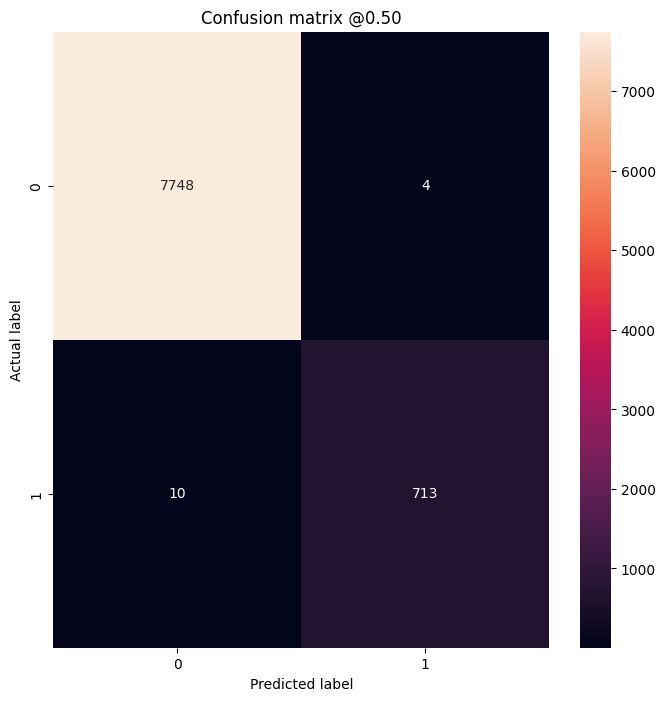

In [159]:
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm_model(df_test_labels, test_predictions_resampled)

Invoke plot_roc_model function on predictions with train data of baseline and test data of  baseline model





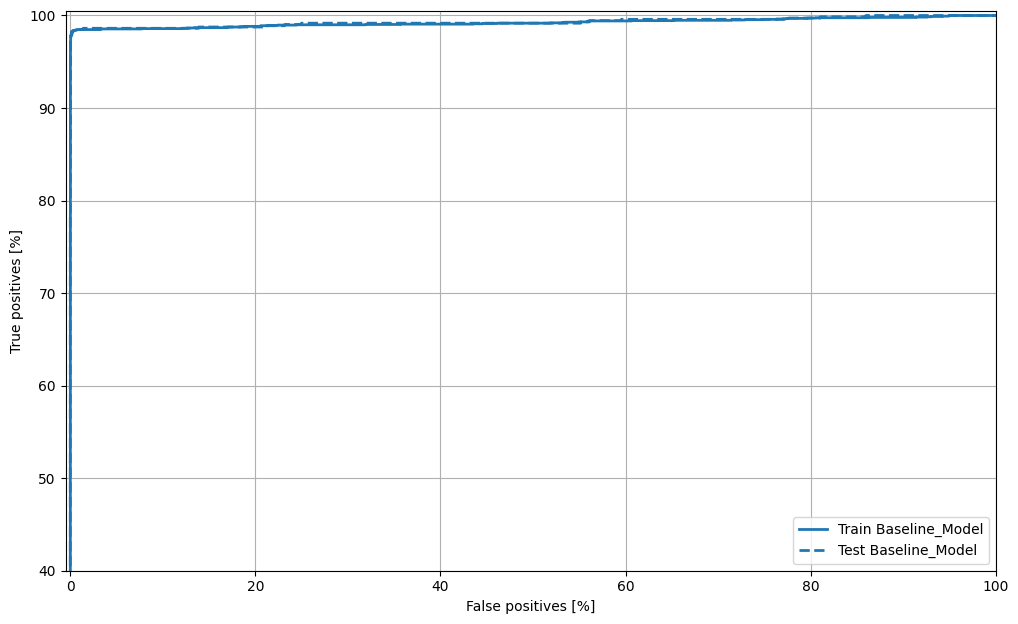

In [160]:
plot_roc_model("Train Baseline_Model", df_train_labels, train_predictions_baseline, color=colors[0])
plot_roc_model("Test Baseline_Model", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

Invoke plot_roc_model function on train data of the class weight and of the test data

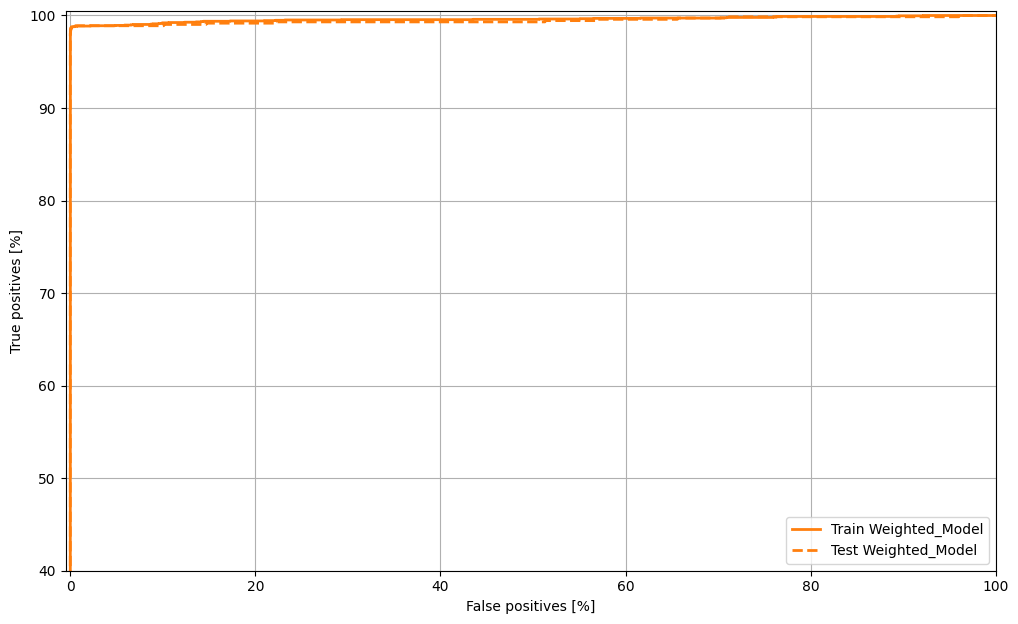

In [161]:
plot_roc_model("Train Weighted_Model", df_train_labels, train_predictions_weighted, color=colors[1])
plot_roc_model("Test Weighted_Model", df_test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

Invoke plot_roc_model function on train data of the resampled and of the test data of the resampled model

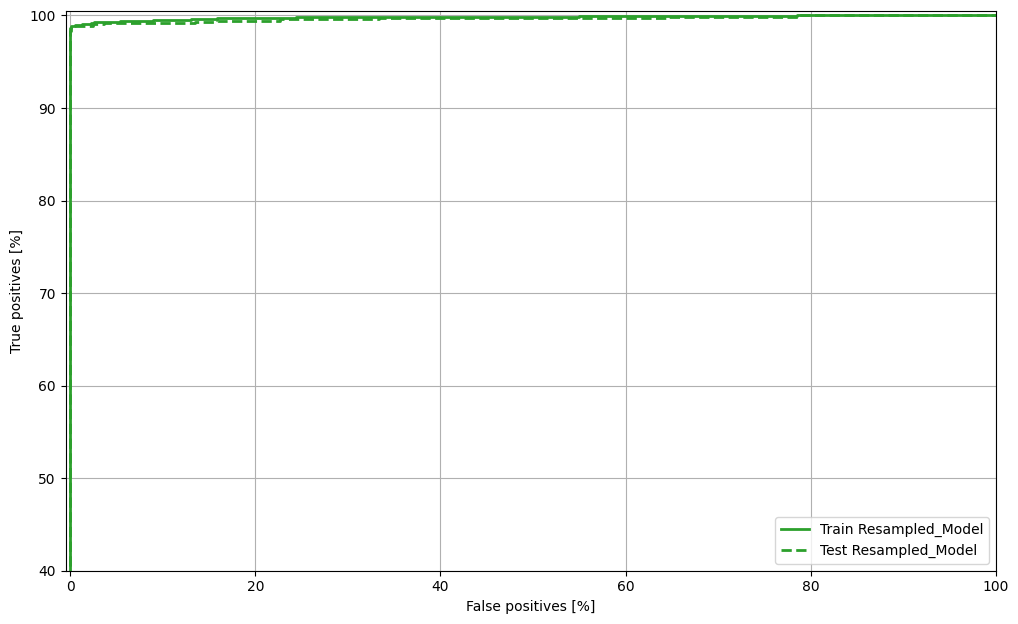

In [162]:
plot_roc_model("Train Resampled_Model", df_train_labels, train_predictions_resampled, color=colors[2])
plot_roc_model("Test Resampled_Model", df_test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

Invoke plot_model_prc on the predictions of baseline model and train data and test data

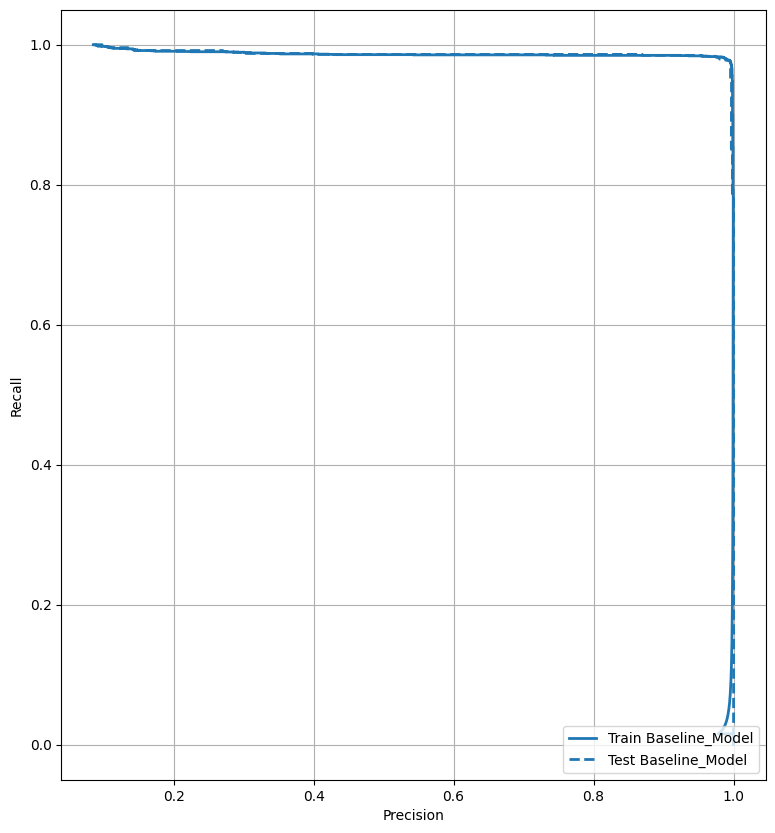

In [163]:
plot_model_prc("Train Baseline_Model", df_train_labels, train_predictions_baseline, color=colors[0])
plot_model_prc("Test Baseline_Model", df_test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

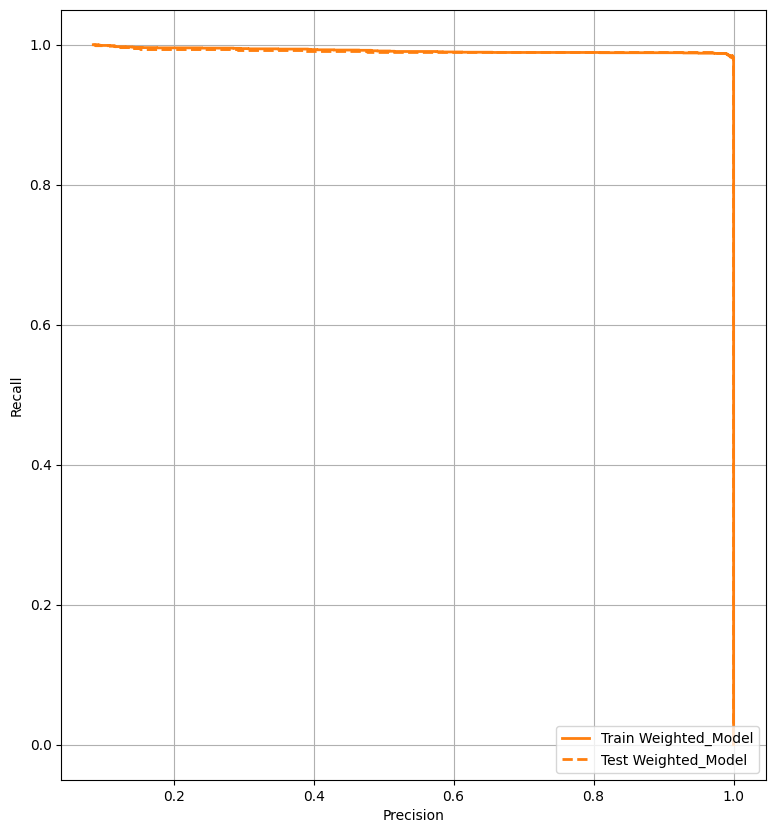

In [164]:
plot_model_prc("Train Weighted_Model", df_train_labels, train_predictions_weighted, color=colors[1])
plot_model_prc("Test Weighted_Model", df_test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

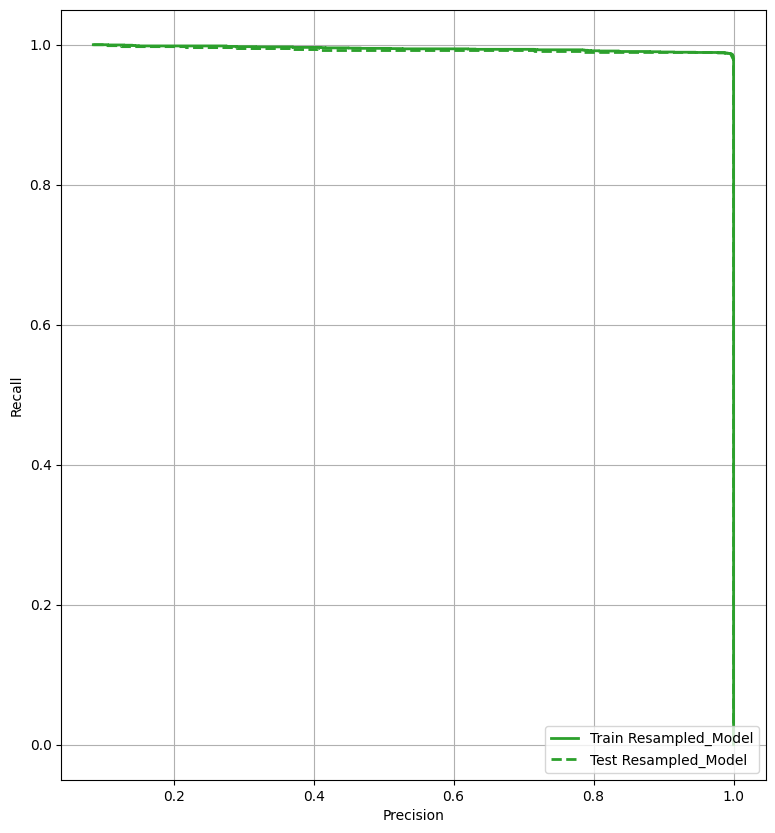

In [165]:
plot_model_prc("Train Resampled_Model", df_train_labels, train_predictions_resampled, color=colors[2])
plot_model_prc("Test Resampled_Model", df_test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [166]:
# Load the row of data you want to test
row_to_test = df.iloc[7]  # Assuming you want to test the first row

# Preprocess the row of data
# Extract features and scale them
test_features = row_to_test.drop('FLAG')  # Assuming 'FLAG' is the target variable
test_features = np.array(test_features).reshape(1, -1)  # Reshape to match the model's input shape
test_features = scale_features.transform(test_features)  # Scale features using the same scaler used in training

# Make predictions using the trained model
predictions = model.predict(test_features)

# Interpret the predictions
predicted_class = 'Fraudulent' if predictions[0] >= 0.5 else 'Non-Fraudulent'
print(f"The predicted class for the row is: {predicted_class}")

1/1 [==============================] - 0s 20ms/step
The predicted class for the row is: Fraudulent


#Creating a suspect list of the fraudulent customers

In [180]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('./model/model.keras')

# Assuming df_test_features is already defined and contains the feature data

# Make predictions
predictions = model.predict(df_test_features)

# Threshold for suspect predictions (adjust as needed)
threshold = 0.5

# Convert predictions to boolean mask
suspect_mask = (predictions >= threshold).flatten()

# Ensure df_test_features is a DataFrame
df_test_features = pd.DataFrame(df_test_features)

# Create a DataFrame to hold suspect predictions
suspect_list = df_test_features[suspect_mask]

# Display the suspect list
print(suspect_list)

# Optionally, save the suspect list to a CSV file
suspect_list.to_csv('suspect_list.csv', index=False)


265/265 [==============================] - 1s 2ms/step
          0         1         2         3         4         5         6     \
31    0.000000  0.002363  0.002918  0.000825  0.000728  0.000863  0.000302   
34    0.000000  0.008051  0.009169  0.002440  0.003217  0.003474  0.002102   
41    0.000000  0.000000  0.000114  0.000335  0.000171  0.000453  0.000034   
44    0.004418  0.009188  0.008620  0.002196  0.002417  0.003067  0.001643   
49    0.002327  0.003120  0.002182  0.000638  0.000841  0.001317  0.000619   
...        ...       ...       ...       ...       ...       ...       ...   
8455  0.002694  0.005650  0.006251  0.001587  0.002200  0.001892  0.001173   
8459  0.000000  0.003797  0.001509  0.002467  0.005135  0.000427  0.000187   
8461  0.002429  0.004880  0.006545  0.002921  0.003888  0.003933  0.002180   
8462  0.000000  0.007168  0.008868  0.002549  0.003524  0.002945  0.001645   
8473  0.000000  0.004809  0.006980  0.001631  0.001968  0.001806  0.000970   

        